# INSY336 Social Speculation for Harnessing Reddit to Forecast Bitcoin Fluctuations

## Model Implementation

In [1]:
# importing needed packages
import requests
import sqlite3
import pandas as pd
import plotly.express as px

In [7]:
# Connect to the database
conn = sqlite3.connect("reddit.db")

In [8]:
# Read reddit posts from database
posts_df = pd.read_sql('select * from posts', conn)
posts_df.head()

,id,title,score,ups,downs,upvote_ratio,url,num_comments,created,body,sentiment,subjectivity
0,1gc6o9k,Michael Saylor Urges Microsoft CEO to Invest i...,1,1,0,0.54,https://coinradar.news/article/6lyUfuVil8PV2ou...,2,2024-10-26,,NaN,NaN
1,1gbyk2y,Is encryption prior to decryption (and ultimat...,3,3,0,0.64,https://www.reddit.com/r/btc/comments/1gbyk2y/...,2,2024-10-26,Building off my last post - for my podcast thi...,0.127242,0.422411
2,1gbxt5q,Bitcoin Whale Accumulation Hits All-Time High ...,0,0,0,0.22,https://www.tradingview.com/chart/BTCUSD/XPENi...,0,2024-10-26,,NaN,NaN
3,1gbpms0,Recurring Payments with CashTokens (GP Shorts),9,9,0,0.77,https://v.redd.it/gbedukbc7vwd1,2,2024-10-25,,NaN,NaN
4,1gbp4ip,Bitcoin Whales Are Buying: Is Retail Missing Out?,0,0,0,0.36,https://cryptochamp.substack.com/p/bitcoin-wha...,4,2024-10-25,,NaN,NaN


In [9]:
#drop na for empty posts
posts_df = posts_df.dropna()

In [10]:
# Read crypto prices from database
crypto_df = pd.read_sql('select * from crypto',conn)

# Calculate daily returns
crypto_df['daily_returns'] = crypto_df['close'].pct_change()
crypto_df

,symbol,date,close,daily_returns
0,BTC,2024-10-26,61752.67,NaN
1,BTC,2024-10-25,61744.48,-0.000133
2,BTC,2024-10-24,62976.58,0.019955
3,BTC,2024-10-23,61791.39,-0.018820
4,BTC,2024-10-22,62400.56,0.009858
...,...,...,...,...
345,BTC,2023-11-16,33346.16,-0.007866
346,BTC,2023-11-15,34916.07,0.047079
347,BTC,2023-11-14,32706.47,-0.063283
348,BTC,2023-11-13,34106.01,0.042791


In [11]:
# Close connection
conn.close()

In [12]:
# change col name
posts_df.columns = ['id', 'title', 'score', 'ups', 'downs', 'upvote_ratio', 'url',
       'num_comments', 'date', 'body', 'sentiment', 'subjectivity']

In [13]:
# check the earliest date
pd.to_datetime(posts_df['date']).min()

Timestamp('2024-07-22 00:00:00')

In [14]:
# aggregate df by mean per day
posts_df_agg = posts_df.groupby('date')[['score','ups','downs','upvote_ratio','num_comments', 'sentiment', 'subjectivity']].agg('mean').reset_index()

In [15]:
# add days of week feature
posts_df_agg['day_of_week'] = pd.to_datetime(posts_df_agg['date']).dt.dayofweek


In [16]:
# check df
posts_df_agg.head()

,date,score,ups,downs,upvote_ratio,num_comments,sentiment,subjectivity,day_of_week
0,2024-07-22,0.000000,0.000000,0.0,0.330,16.000000,0.100000,0.580000,0
1,2024-07-23,4.500000,4.500000,0.0,0.565,9.000000,0.013068,0.447159,1
2,2024-07-24,10.333333,10.333333,0.0,0.470,13.333333,-0.011905,0.338889,2
3,2024-07-25,5.500000,5.500000,0.0,0.655,9.000000,0.144152,0.364208,3
4,2024-07-26,17.666667,17.666667,0.0,0.740,20.333333,0.179189,0.483967,4


In [17]:
# Merge dataframes on date

df = posts_df_agg.merge(crypto_df, on='date', how='inner')
df.head()

,date,score,ups,downs,upvote_ratio,num_comments,sentiment,subjectivity,day_of_week,symbol,close,daily_returns
0,2024-07-22,0.000000,0.000000,0.0,0.330,16.000000,0.100000,0.580000,0,BTC,62030.69,0.020981
1,2024-07-23,4.500000,4.500000,0.0,0.565,9.000000,0.013068,0.447159,1,BTC,60755.96,0.006994
2,2024-07-24,10.333333,10.333333,0.0,0.470,13.333333,-0.011905,0.338889,2,BTC,60333.99,-0.005211
3,2024-07-25,5.500000,5.500000,0.0,0.655,9.000000,0.144152,0.364208,3,BTC,60650.01,-0.030589
4,2024-07-26,17.666667,17.666667,0.0,0.740,20.333333,0.179189,0.483967,4,BTC,62563.79,0.001213


In [18]:
# check shape
df.shape

(92, 12)

In [19]:
# Line plot of close
fig = px.line(df, x="date", y=["close"])
fig.show()

In [20]:
# Scatter plot of daily returns vs sentiment scores
fig = px.scatter(df, x="sentiment", y="close", width=800, height=800)
fig.show()

In [21]:
# Correlation matrix of daily returns, sentiment and subjectivity scores
corrmatrix = df[['close','sentiment','subjectivity']].corr()
corrmatrix

,close,sentiment,subjectivity
close,1.000000,0.061035,0.033894
sentiment,0.061035,1.000000,0.191346
subjectivity,0.033894,0.191346,1.000000


In [22]:
# Heatmap of correlation matrix
fig = px.imshow(corrmatrix)
fig.show()

In [23]:
# import model building packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from linear_model import LinearRegression
import matplotlib.pyplot as plt

In [24]:
# define X and y
X = df.drop(columns=['close','daily_returns','date','symbol'])
y = df['close']

In [25]:
# Get the index for splitting the data (80% training, 20% testing)
split_index = int(len(X) * 0.8)

# Split the data into training and testing sets sequentially
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [26]:
base_model = LinearRegression()
# train
base_model.fit(X_train,y_train)
# prediction
yh_train = base_model.predict(X_train)
yh_test = base_model.predict(X_test)

mse_train = mean_squared_error(y_pred=yh_train, y_true=y_train)
mse_test = mean_squared_error(y_pred=yh_test, y_true=y_test)

print(f'Train MSE for baseline model is {mse_train}')
print(f'Test MSE for baseline model is {mse_test}')


Train MSE for baseline model is 10847357.758584945
Test MSE for baseline model is 33057747.020910308


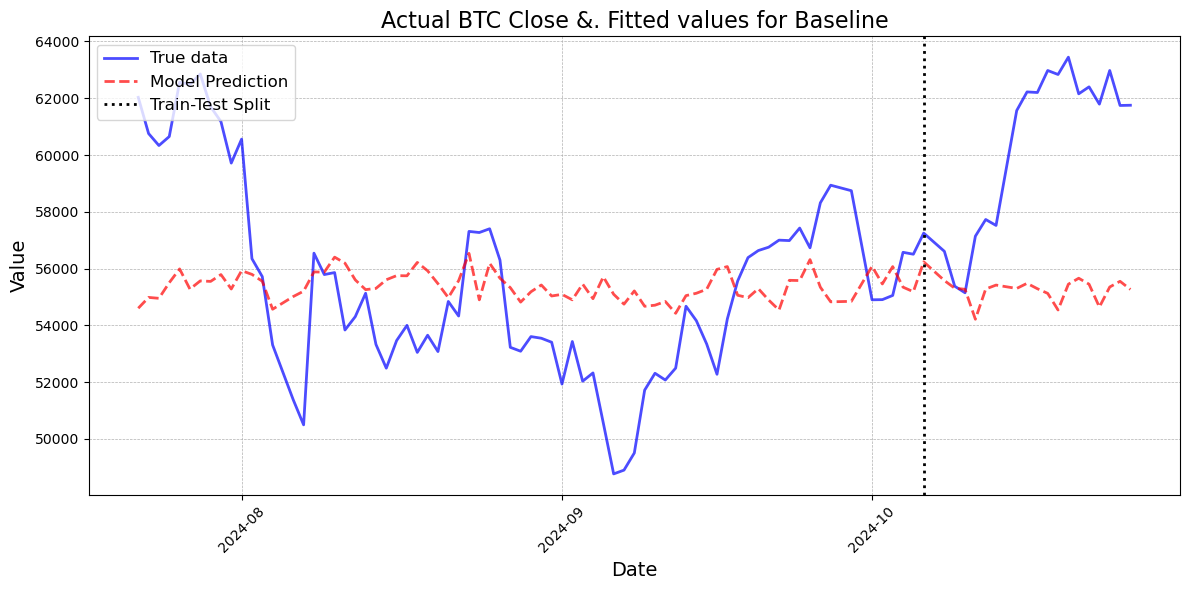

In [27]:
import matplotlib.dates as mdates

split_date = pd.to_datetime(df['date'].iloc[split_index]) 

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(pd.to_datetime(df['date']), y, color='blue', linestyle='-', linewidth=2, label='True data', alpha=0.7)
plt.plot(pd.to_datetime(df['date']), base_model.predict(X), color='red', linestyle='--', linewidth=2, label='Model Prediction', alpha=0.7)
plt.axvline(x=split_date, color='black', linestyle=':', linewidth=2, label='Train-Test Split')

plt.title('Actual BTC Close &. Fitted values for Baseline', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust the interval for tick marks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend(fontsize=12, loc='upper left')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [28]:
# implement MLP using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
y_scaler = StandardScaler()
y_train_std = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_std = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert numpy arrays to torch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
y_train = torch.tensor(y_train_std, dtype=torch.float32).view(-1, 1)  
y_test = torch.tensor(y_test_std, dtype=torch.float32).view(-1, 1)


In [101]:
from mlp_dropout import MLP

# Hyperparameters
input_size = X_train_std.shape[1]  # Number of features
hidden_size1 = 56  # Neurons in the first hidden layer
hidden_size2 = 16  # Neurons in the second hidden layer
output_size = 1  # Single output for regression
learning_rate = 0.0001
num_epochs = 50000  # Consider lowering this initially to avoid long training times

# Initialize model
model = MLP(input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.3)

# define loss and optimizer
criterion = nn.MSELoss()  # MSE
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # adam for smoother optimization path

## normal implemenation
# # train the model
# for epoch in range(num_epochs):
#     model.train()  # Set the model to training mode

#     # compute loss
#     outputs = model(X_train_std)
#     loss = criterion(outputs, y_train)

#     # backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Print the loss every 100 epochs
#     if (epoch+1) % 10000 == 0 or epoch+1==num_epochs:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [106]:
# hyperparameters for early stopping
patience = 500  # Number of epochs to wait for improvement
min_delta = 0.0000001  # Minimum change to qualify as an improvement

# Initialize variables for early stopping
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_std)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Check validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_predictions = model(X_test_std)
        val_loss = criterion(val_predictions, y_test).item()

    # Early stopping logic
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        epochs_no_improve = 0
        # Optionally save the best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1

    # Stop training if no improvement for 'patience' epochs
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        break

    # Print training progress
    if (epoch + 1) % 10000 == 0 or epoch + 1 == num_epochs:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Early stopping at epoch 1213 with validation loss: 2.8621


In [107]:
# save trained model
model_save_path = "mlp_trained_model.pth"
torch.save(model.state_dict(), model_save_path)

In [108]:
# evaluate the model
X_std = scaler.fit_transform(X)
X_std = torch.tensor(X_std, dtype=torch.float32)


model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # predictions and MSE on training set
    train_predictions = model(X_train_std)
    train_mse = criterion(train_predictions, y_train)
    
    # predictions and MSE on test set
    test_predictions = model(X_test_std)
    test_mse = criterion(test_predictions, y_test)

    yh_all = model(X_std)
    
    # Print MSE results
    print(f'Mean Squared Error on training set: {train_mse.item():.4f}')
    print(f'Mean Squared Error on test set: {test_mse.item():.4f}')

Mean Squared Error on training set: 0.6813
Mean Squared Error on test set: 2.8621


In [109]:
# transform back to original scale
yh_allback = y_scaler.inverse_transform(yh_all.numpy())

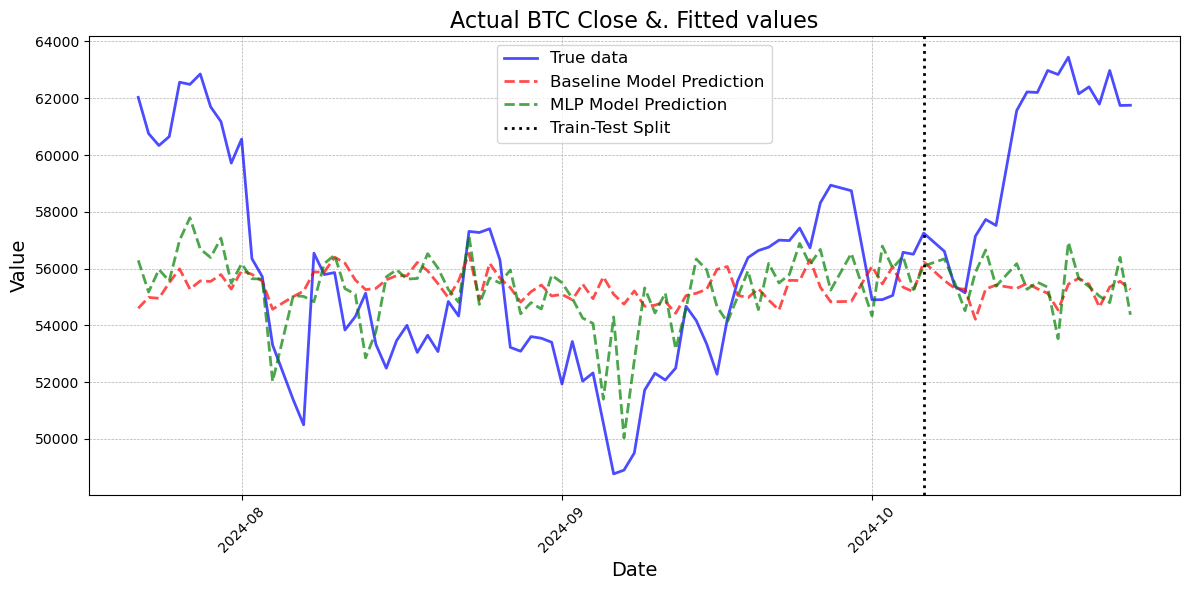

In [110]:

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(pd.to_datetime(df['date']), y, color='blue', linestyle='-', linewidth=2, label='True data', alpha=0.7)
plt.plot(pd.to_datetime(df['date']), base_model.predict(X), color='red', linestyle='--', linewidth=2, label='Baseline Model Prediction', alpha=0.7)
plt.plot(pd.to_datetime(df['date']), yh_allback, color='green', linestyle='--', linewidth=2, label='MLP Model Prediction', alpha=0.7)
plt.axvline(x=split_date, color='black', linestyle=':', linewidth=2, label='Train-Test Split')

plt.title('Actual BTC Close &. Fitted values', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust the interval for tick marks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.legend(fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()